In [3]:
# -----------------------------
# 1. Setup Kaggle API
# -----------------------------
from google.colab import files
files.upload()   # Upload kaggle.json from your system

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# -----------------------------
# 2. Download & Extract Dataset
# -----------------------------
!kaggle datasets download -d shayanfazeli/heartbeat

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
License(s): unknown
  0% 0.00/98.8M [00:00<?, ?B/s]
100% 98.8M/98.8M [00:00<00:00, 1.35GB/s]


In [6]:
# 1. Unzip the dataset (replace with your uploaded file path if different)
import zipfile
import os

zip_path = "/content/heartbeat.zip"   # your uploaded dataset
extract_dir = "/content/heartbeat_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Files extracted to:", extract_dir)
print("Extracted files:", os.listdir(extract_dir))

Files extracted to: /content/heartbeat_dataset
Extracted files: ['mitbih_train.csv', 'mitbih_test.csv', 'ptbdb_normal.csv', 'ptbdb_abnormal.csv']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.6998 - loss: 1.4314 - val_accuracy: 0.9383 - val_loss: 0.5697 - learning_rate: 0.0010
Epoch 2/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9284 - loss: 0.5879 - val_accuracy: 0.9503 - val_loss: 0.4040 - learning_rate: 0.0010
Epoch 3/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9379 - loss: 0.4423 - val_accuracy: 0.9575 - val_loss: 0.3141 - learning_rate: 0.0010
Epoch 4/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9453 - loss: 0.3462 - val_accuracy: 0.9580 - val_loss: 0.2571 - learning_rate: 0.0010
Epoch 5/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9480 - loss: 0.2955 - val_accuracy: 0.9592 - val_loss: 0.2281 - learning_rate: 0.0010
Epoch 6/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9481 - loss: 0.2726 - val_accuracy: 0.9575 - val_loss: 0.2194 - learning_rate: 0.0010
Epoch 7/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9492 - loss: 

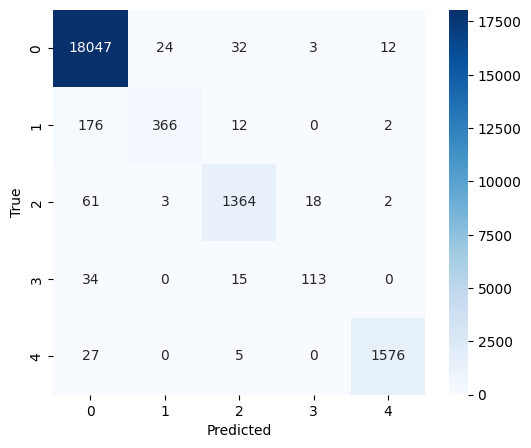

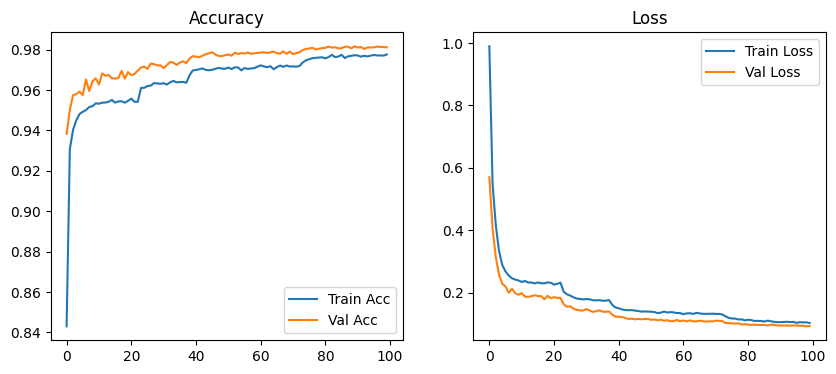

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -----------------------
# Load Dataset
# -----------------------
df = pd.read_csv("/content/heartbeat_dataset/mitbih_train.csv", header=None)
df_test = pd.read_csv("/content/heartbeat_dataset/mitbih_test.csv", header=None)

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].astype(int).values

X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].astype(int).values

# -----------------------
# Preprocessing
# -----------------------
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------
# Build ANN with regularization
# -----------------------
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------
# Callbacks
# -----------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# -----------------------
# Training
# -----------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# -----------------------
# Evaluation
# -----------------------
y_pred = np.argmax(model.predict(X_test), axis=-1)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot Training Curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()